## **Modelling**

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7922d1104900>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/xgboost.libs/libgomp-24e2ab19.so.1.0.0

              precision    recall  f1-score   support

           0       0.99      0.92      0.95     22875
           1       0.51      0.88      0.65      2125

    accuracy                           0.92     25000
   macro avg       0.75      0.90      0.80     25000
weighted avg       0.95      0.92      0.93     25000

Recall Score: 88.24%


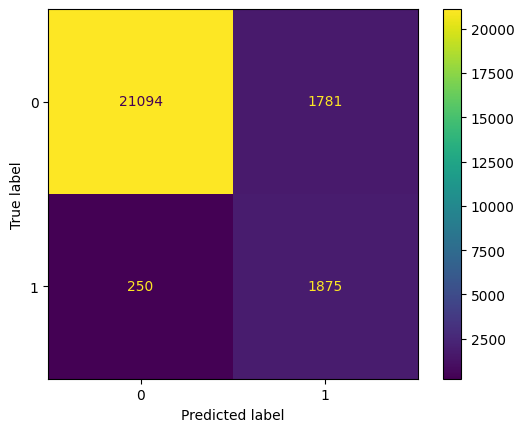

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Load dataset
df = pd.read_csv("/diabetes_prediction_dataset.csv")

# Define categorical and numerical columns
cat_col = ['gender', 'smoking_history']
num_col = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Define pipelines for numerical and categorical transformations
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_col),
        ('cat', categorical_transformer, cat_col)
    ], remainder='passthrough'
)

# Split dataset into train and test
X = df.drop(columns=['diabetes'])
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Apply transformations
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

# Convert back to DataFrame after SMOTE
X_train_res = pd.DataFrame(X_train_res, columns=preprocessor.get_feature_names_out())

# Compute class imbalance ratio
class_counts = df['diabetes'].value_counts()
majority_class = class_counts[0]
minority_class = class_counts[1]
ratio = majority_class / minority_class

# Feature Selection using RandomForestClassifier
feature_selector = RandomForestClassifier(random_state=42)
feature_selector.fit(X_train_res, y_train_res)
selected_features = SelectFromModel(feature_selector, threshold='median', prefit=True)
X_train_selected = selected_features.transform(X_train_res)
X_test_selected = selected_features.transform(X_test_transformed)

# Define final model pipeline with XGBoost
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', selected_features),
    ('classifier', XGBClassifier(
        scale_pos_weight=ratio,
        eval_metric='logloss',
        random_state=42
    ))
])

# Train model
clf.fit(X_train, y_train)

# ✅ Save the trained model in XGBoost format
clf.named_steps["classifier"].save_model("Pipeline_clf.json")

# ✅ Load the trained model for Flask app
model = XGBClassifier()
model.load_model("Pipeline_clf.json")

# Make predictions
predictions = model.predict(X_test_selected)

# Evaluate performance
print(classification_report(y_test, predictions))
print(f"Recall Score: {round(recall_score(y_test, predictions) * 100, 2)}%")

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [16:35:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but SelectFromModel was fitted with feature names
  warnings.warn(


              precision    recall  f1-score   support

           0       0.99      0.92      0.95     22875
           1       0.51      0.88      0.65      2125

    accuracy                           0.92     25000
   macro avg       0.75      0.90      0.80     25000
weighted avg       0.95      0.92      0.93     25000

Recall Score: 88.24%


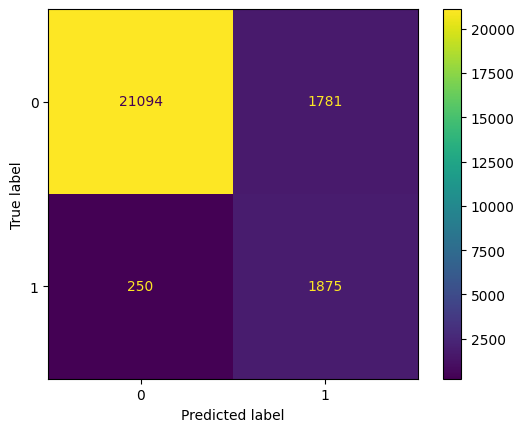

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, recall_score, confusion_matrix, ConfusionMatrixDisplay
from joblib import dump, load
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# Load dataset
df = pd.read_csv("/diabetes_prediction_dataset.csv")

# Define categorical and numerical columns
cat_col = ['gender', 'smoking_history']
num_col = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Define pipelines for numerical and categorical transformations
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_col),
        ('cat', categorical_transformer, cat_col)
    ], remainder='passthrough'
)

# Split dataset into train and test
X = df.drop(columns=['diabetes'])
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Apply transformations
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

# Convert back to DataFrame after SMOTE
X_train_res = pd.DataFrame(X_train_res, columns=preprocessor.get_feature_names_out())

# Compute class imbalance ratio
class_counts = df['diabetes'].value_counts()
majority_class = class_counts[0]
minority_class = class_counts[1]
ratio = majority_class / minority_class

# Feature Selection using RandomForestClassifier
feature_selector = RandomForestClassifier(random_state=42)
feature_selector.fit(X_train_res, y_train_res)
selected_features = SelectFromModel(feature_selector, threshold='median', prefit=True)
X_train_selected = selected_features.transform(X_train_res)
X_test_selected = selected_features.transform(X_test_transformed)

# Define final model pipeline with XGBoost
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selection', selected_features),
    ('classifier', XGBClassifier(
        scale_pos_weight=ratio,
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ))
])

# Train model
clf.fit(X_train, y_train)

# Save the trained model
dump(clf, "Pipeline_clf.joblib")

# Load the trained model
pretrained_model = load("Pipeline_clf.joblib")

# Make predictions
predictions = pretrained_model.predict(X_test)

# Evaluate performance
print(classification_report(y_test, predictions))
print(f"Recall Score: {round(recall_score(y_test, predictions) * 100, 2)}%")

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()


In [ ]:
import xgboost as xgb
print(xgb.__version__)


2.1.4


In [ ]:
!pip install --upgrade xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.6 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.1.4
    Uninstalling xgboost-2.1.4:
      Successfully uninstalled xgboost-2.1.4


In [ ]:
import xgboost as xgb
print(xgb.__version__)


2.1.4


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:31:41] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

           0       0.99      0.93      0.96     22875
           1       0.53      0.88      0.67      2125

    accuracy                           0.92     25000
   macro avg       0.76      0.91      0.81     25000
weighted avg       0.95      0.92      0.93     25000

Recall Score: 88.19%


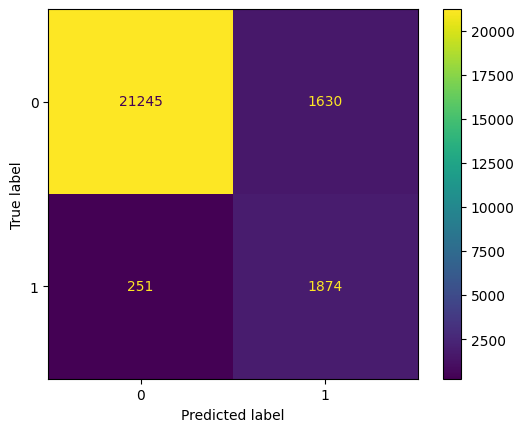

Diabetes Prediction: Positive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, recall_score, confusion_matrix, ConfusionMatrixDisplay
from joblib import dump, load

# Load dataset
df = pd.read_csv("/diabetes_prediction_dataset.csv")

# Define categorical and numerical columns
cat_col = ['gender', 'smoking_history']
num_col = ['age', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# Define pipelines for numerical and categorical transformations
numeric_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformations using ColumnTransformer
preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_col),
    ('cat', categorical_transformer, cat_col)
], remainder='passthrough')

# Split dataset into train and test
X = df.drop(columns=['diabetes'])
y = df['diabetes']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Apply transformations
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_transformed, y_train)

# Compute class imbalance ratio
class_counts = df['diabetes'].value_counts()
majority_class = class_counts[0]
minority_class = class_counts[1]
ratio = majority_class / minority_class

# Define the final model pipeline using XGBoost
clf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=ratio,
                                 eval_metric='logloss',
                                 use_label_encoder=False,
                                 random_state=42))
])

# Train model
clf.fit(X_train, y_train)

# Save the trained model
dump(clf, "XGBoost_Diabetes_Model.joblib")

# Load the trained model
pretrained_model = load("XGBoost_Diabetes_Model.joblib")

# Make predictions
predictions = pretrained_model.predict(X_test)

# Evaluate performance
print(classification_report(y_test, predictions))
print(f"Recall Score: {round(recall_score(y_test, predictions) * 100, 2)}%")

# Plot confusion matrix
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

import pandas as pd
import numpy as np
from joblib import load

# Load the trained model
pretrained_model = load("XGBoost_Diabetes_Model.joblib")

# Define a sample inference input
sample_data = pd.DataFrame({
    'gender': ['Male'],
    'smoking_history': ['current'],
    'age': [60],
    'bmi': [33.0],
    'HbA1c_level': [7.8],
    'blood_glucose_level': [210],
    'hypertension': [1],
    'heart_disease': [1]
})

# Ensure columns are in the correct order
sample_data = sample_data[pretrained_model.named_steps['preprocessor'].feature_names_in_]

# Make predictions using the trained model
prediction = pretrained_model.predict(sample_data)
probability = pretrained_model.predict_proba(sample_data)[:, 1][0]  # Get probability of diabetes

# Adjusted risk scoring function
scaled_risk_score = (probability * 0.8 + 0.1) * 100  # Scale away from extreme 0% and 100%
risk_score_percentage = round(scaled_risk_score, 2)

# Define risk levels
if risk_score_percentage < 30:
    risk_level = "Low Risk"
elif 30 <= risk_score_percentage < 70:
    risk_level = "Moderate Risk"
else:
    risk_level = "High Risk"

# Define health recommendations based on input factors
health_advice = []

# Smoking advice
if sample_data['smoking_history'][0] in ['current', 'former']:
    health_advice.append("Quit smoking to lower your risk of diabetes and cardiovascular diseases.")

# BMI category
if sample_data['bmi'][0] < 18.5:
    bmi_risk = "Underweight (Moderate Risk)"
elif 18.5 <= sample_data['bmi'][0] < 24.9:
    bmi_risk = "Normal (Low Risk)"
elif 25 <= sample_data['bmi'][0] < 29.9:
    bmi_risk = "Overweight (Moderate Risk)"
else:
    bmi_risk = "Obese (High Risk)"
    health_advice.append("Consider a healthy diet and exercise to reduce obesity-related risks.")

# HbA1c level category
if sample_data['HbA1c_level'][0] < 5.7:
    hba1c_risk = "Normal (Low Risk)"
elif 5.7 <= sample_data['HbA1c_level'][0] < 6.5:
    hba1c_risk = "Prediabetes (Moderate Risk)"
    health_advice.append("Monitor your diet and exercise to prevent diabetes.")
else:
    hba1c_risk = "Diabetic (High Risk)"
    health_advice.append("Consult a doctor to manage high blood sugar levels.")

# Blood glucose level category
if sample_data['blood_glucose_level'][0] < 140:
    glucose_risk = "Normal (Low Risk)"
elif 140 <= sample_data['blood_glucose_level'][0] < 199:
    glucose_risk = "Prediabetes (Moderate Risk)"
    health_advice.append("Control sugar intake and maintain an active lifestyle.")
else:
    glucose_risk = "High (High Risk)"
    health_advice.append("High blood glucose detected. Seek medical guidance.")

# Hypertension risk
hypertension_risk = "Yes (High Risk)" if sample_data['hypertension'][0] == 1 else "No (Low Risk)"
if sample_data['hypertension'][0] == 1:
    health_advice.append("Manage blood pressure with a healthy lifestyle and checkups.")

# Heart disease risk
heart_disease_risk = "Yes (High Risk)" if sample_data['heart_disease'][0] == 1 else "No (Low Risk)"
if sample_data['heart_disease'][0] == 1:
    health_advice.append("Heart disease detected. Follow a heart-healthy lifestyle.")

# Display results
print("\n🔹 **Diabetes Prediction:**", "Positive" if prediction[0] == 1 else "Negative")
print(f"🔹 **Risk Prediction Score:** {risk_score_percentage}% ({risk_level})")

print("\n📊 **Health Risk Levels:**")
print(f"   - BMI: {bmi_risk}")
print(f"   - HbA1c Level: {hba1c_risk}")
print(f"   - Blood Glucose Level: {glucose_risk}")
print(f"   - Hypertension: {hypertension_risk}")
print(f"   - Heart Disease: {heart_disease_risk}")

print("\n🩺 **Health Recommendations:**")
for advice in health_advice:
    print(f"   - {advice}")



## ***INFERENCE***

In [ ]:
import pandas as pd
import numpy as np
from joblib import load

# Load the trained model
pretrained_model = load("XGBoost_Diabetes_Model.joblib")

# Define a sample inference input with all required columns (high-risk case)
sample_data = pd.DataFrame({
    'gender': ['Male'],
    'smoking_history': ['current'],  # Smoker
    'age': [60],  # Older age
    'bmi': [33.0],  # Obese BMI
    'HbA1c_level': [7.8],  # High HbA1c (diabetic)
    'blood_glucose_level': [210],  # High glucose level
    'hypertension': [1],  # Has hypertension
    'heart_disease': [1]  # Has heart disease
})

# Ensure columns are in the same order as training data
sample_data = sample_data[pretrained_model.named_steps['preprocessor'].feature_names_in_]

# Make prediction using the trained model
prediction = pretrained_model.predict(sample_data)

# Print the prediction result
print("Diabetes Prediction:", "Positive" if prediction[0] == 1 else "Negative")


Diabetes Prediction: Positive


In [ ]:
import pandas as pd
import numpy as np
from joblib import load

# Load the trained model
pretrained_model = load("XGBoost_Diabetes_Model.joblib")

# Define a sample inference input
sample_data = pd.DataFrame({
    'gender': ['Male'],
    'smoking_history': ['current'],
    'age': [60],
    'bmi': [33.0],
    'HbA1c_level': [7.8],
    'blood_glucose_level': [210],
    'hypertension': [1],
    'heart_disease': [1]
})

# Ensure columns are in the correct order
sample_data = sample_data[pretrained_model.named_steps['preprocessor'].feature_names_in_]

# Make predictions using the trained model
prediction = pretrained_model.predict(sample_data)
probability = pretrained_model.predict_proba(sample_data)[:, 1][0]  # Get probability of diabetes

# Adjusted risk scoring function
scaled_risk_score = (probability * 0.8 + 0.1) * 100  # Scale away from extreme 0% and 100%
risk_score_percentage = round(scaled_risk_score, 2)

# Define risk levels
if risk_score_percentage < 30:
    risk_level = "Low Risk"
elif 30 <= risk_score_percentage < 70:
    risk_level = "Moderate Risk"
else:
    risk_level = "High Risk"

# Define health recommendations based on input factors
health_advice = []

# Smoking advice
if sample_data['smoking_history'][0] in ['current', 'former']:
    health_advice.append("Quit smoking to lower your risk of diabetes and cardiovascular diseases.")

# BMI category
if sample_data['bmi'][0] < 18.5:
    bmi_risk = "Underweight (Moderate Risk)"
elif 18.5 <= sample_data['bmi'][0] < 24.9:
    bmi_risk = "Normal (Low Risk)"
elif 25 <= sample_data['bmi'][0] < 29.9:
    bmi_risk = "Overweight (Moderate Risk)"
else:
    bmi_risk = "Obese (High Risk)"
    health_advice.append("Consider a healthy diet and exercise to reduce obesity-related risks.")

# HbA1c level category
if sample_data['HbA1c_level'][0] < 5.7:
    hba1c_risk = "Normal (Low Risk)"
elif 5.7 <= sample_data['HbA1c_level'][0] < 6.5:
    hba1c_risk = "Prediabetes (Moderate Risk)"
    health_advice.append("Monitor your diet and exercise to prevent diabetes.")
else:
    hba1c_risk = "Diabetic (High Risk)"
    health_advice.append("Consult a doctor to manage high blood sugar levels.")

# Blood glucose level category
if sample_data['blood_glucose_level'][0] < 140:
    glucose_risk = "Normal (Low Risk)"
elif 140 <= sample_data['blood_glucose_level'][0] < 199:
    glucose_risk = "Prediabetes (Moderate Risk)"
    health_advice.append("Control sugar intake and maintain an active lifestyle.")
else:
    glucose_risk = "High (High Risk)"
    health_advice.append("High blood glucose detected. Seek medical guidance.")

# Hypertension risk
hypertension_risk = "Yes (High Risk)" if sample_data['hypertension'][0] == 1 else "No (Low Risk)"
if sample_data['hypertension'][0] == 1:
    health_advice.append("Manage blood pressure with a healthy lifestyle and checkups.")

# Heart disease risk
heart_disease_risk = "Yes (High Risk)" if sample_data['heart_disease'][0] == 1 else "No (Low Risk)"
if sample_data['heart_disease'][0] == 1:
    health_advice.append("Heart disease detected. Follow a heart-healthy lifestyle.")

# Display results
print("\n🔹 **Diabetes Prediction:**", "Positive" if prediction[0] == 1 else "Negative")
print(f"🔹 **Risk Prediction Score:** {risk_score_percentage}% ({risk_level})")

print("\n📊 **Health Risk Levels:**")
print(f"   - BMI: {bmi_risk}")
print(f"   - HbA1c Level: {hba1c_risk}")
print(f"   - Blood Glucose Level: {glucose_risk}")
print(f"   - Hypertension: {hypertension_risk}")
print(f"   - Heart Disease: {heart_disease_risk}")

print("\n🩺 **Health Recommendations:**")
for advice in health_advice:
    print(f"   - {advice}")



🔹 **Diabetes Prediction:** Positive
🔹 **Risk Prediction Score:** 90.0% (High Risk)

📊 **Health Risk Levels:**
   - BMI: Obese (High Risk)
   - HbA1c Level: Diabetic (High Risk)
   - Blood Glucose Level: High (High Risk)
   - Hypertension: Yes (High Risk)
   - Heart Disease: Yes (High Risk)

🩺 **Health Recommendations:**
   - Quit smoking to lower your risk of diabetes and cardiovascular diseases.
   - Consider a healthy diet and exercise to reduce obesity-related risks.
   - Consult a doctor to manage high blood sugar levels.
   - High blood glucose detected. Seek medical guidance.
   - Manage blood pressure with a healthy lifestyle and checkups.
   - Heart disease detected. Follow a heart-healthy lifestyle.


In [ ]:
print(f"X_train_res shape: {X_train_res.shape}")
print(f"y_train_res shape: {y_train_res.shape}")


X_train_res shape: (137250, 15)
y_train_res shape: (137250,)
